#SIM Patter

###The Python version

Below is the Mathematica code for reference.

```mathematica

patterntabArb[vecA_, period_, onfrac_, phaseInd_, phaseOffset_: 0., 
  nphases_: 5, sizex_: 1280, sizey_: 1024] := Block[
  {veckA = {1., -1.} Reverse[vecA], vecB, area, onpix, phaseStep},
  
  vecB = veckA/Norm[vecA]*period; area = vecB.veckA; 
  onpix = area * onfrac; phaseStep = vecB/nphases;
  
  Table[If[
    Mod[({x, 
          y} - (phaseStep*phaseInd + 
           phaseOffset/(2. \[Pi])*vecB)).veckA, area] >= onpix, 0., 
    1.], {y, 0, sizey - 1}, {x, 0, sizex - 1}]
  ]

```

In [1]:
%pylab inline
import time
import seaborn as sns
from scipy import ndimage
from scipy.optimize import curve_fit
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

Populating the interactive namespace from numpy and matplotlib


In [2]:
def patterntabArbOld(vecA, period, onfrac, phaseInd, phaseOffset = 0., nphases =5, sizex =1280, sizey =1024):
    veckA = array([[0,1],[-1,0]]).dot(vecA)
    vecB = veckA/norm(vecA)*period
    area = vecB.dot(veckA)
    onpix = area*onfrac
    phaseStep = vecB/nphases
    
    toReturn = zeros((sizex,sizey))
    
    val = (phaseStep*phaseInd+phaseOffset/(2*pi)*vecB)
    
    #return array([[mod((array([i,j])-val).dot(veckA),area) < onpix for i in range(1,sizex)] for j in range(1,sizey)])
    
    for i in range(sizex):
        for j in range(sizey):
            if mod((array([i,j])-val).dot(veckA),area) < onpix:
                toReturn[i,j] = 1
            else:
                toReturn[i,j] = 0
            
    return toReturn.T

In [3]:
def patterntabArb(vecA, period, onfrac = 0.5, phaseInd = 0., phaseOffset = 0., nphases =5, sizex =2048, sizey =1536):
    veckA = array([[0,1],[-1,0]]).dot(vecA)
    vecB = veckA/norm(vecA)*period
    area = vecB.dot(veckA)
    onpix = area*onfrac
    phaseStep = vecB/nphases
    
    val = (phaseStep*phaseInd+phaseOffset/(2*pi)*vecB)
    
    xx, yy = meshgrid(arange(sizex),arange(sizey))
    my_grid = dstack((xx,yy))
    
    
    return mod((my_grid-val).dot(veckA),area) < onpix

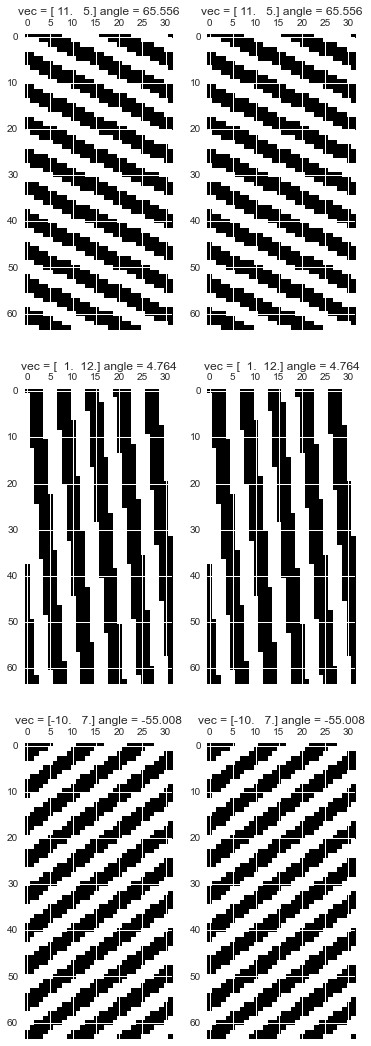

In [4]:
angles = array([[  11.,  5.],
       [ 1.,  12.],
       [-10.,  7.]])
fig, ax = subplots(3,2,squeeze=True, figsize=(6,18))
for i,angle in enumerate(angles):
    ax[i,0].matshow(patterntabArb(angle, 6.28, 0.5, 0, 0., 5,sizex=32,sizey=64),cmap='Greys')
    ax[i,0].set_title("vec = {0} angle = {1:.3f}".format(angle,180/pi*arctan2(angle[0],angle[1])))
    ax[i,1].matshow(patterntabArbOld(angle, 6.28, 0.5, 0, 0., 5,sizex=32,sizey=64),cmap='Greys')
    ax[i,1].set_title("vec = {0} angle = {1:.3f}".format(angle,180/pi*arctan2(angle[0],angle[1])))

In [5]:
%timeit patterntabArbOld(array([12, -1]), 4.8277, 0.5, 0, 0., 5, 1024,1024)
%timeit patterntabArb(array([12, -1]), 4.8277, 0.5, 0, 0., 5, 1024,1024)

1 loops, best of 3: 26.4 s per loop
1 loops, best of 3: 205 ms per loop


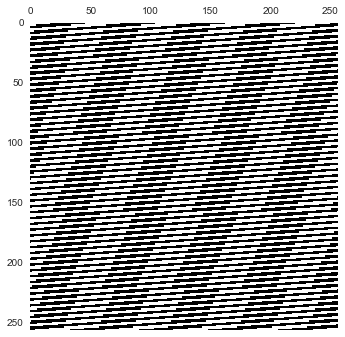

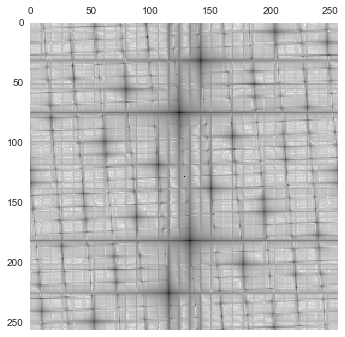

In [5]:
pat =  patterntabArb(array([12, -1]), 4.8, 0.5, 0, 0., 5, 256,256)
pat_fft = ifftshift(fftn(fftshift(pat)))
matshow(pat,cmap='Greys')
grid('off')
matshow(log(abs(pat_fft)))
grid('off')

```matlab
(*A function to calculate the best vectors for a set of orientations. \
The number of orientations is numanlges and Amp is the approximate \
length of the vectors, x is a phase offset*)

Angles[\[Phi]_, numangles_, Amp_] := 
 Table[Round[
   Amp*{Cos[\[Theta]], 
     Sin[\[Theta]]}], {\[Theta], (Table[
       i, {i, 0., (numangles - 1)}]*\[Pi]/1./numangles + \[Phi])}]

(*A function that calculates the difference between the desired \
angles and the calculated ones*)

AngleDiff[\[Phi]_, numangles_, Amp_] :=
 Mean[
  Abs[\[Pi]/1./numangles -
    Differences[
     Map[VectorAngle[{1., 0.}, #] &, Angles[\[Phi], numangles, Amp]]
     (*ToPolarCoordinates[1.0*Angles[\[Phi],numangles,Amp]][[;;,
     2]]*)
     ]
   ]
  ]
(*A function that gives the optimized orientation vectors for number \
of orientations numangles*)

BestAngles[numangles_, Amp_] :=
 Block[{data, bestOffset},
  data = Table[{x, AngleDiff[x, numangles, Amp]}, {x, 0, 2*\[Pi], 
     0.01 (*This should probably be a function of Amp*)}];
  bestOffset = TakeSmallestBy[data, Last, 1][[1, 1]];
  Angles[bestOffset, numangles, Amp]
  ]

(*Inside look at BestAngles*)

data = Table[{x, AngleDiff[x, 3., 12.]}, {x, 0., 2.*\[Pi], 0.01}];
ListLinePlot[data]
bestOffset = TakeSmallestBy[data, Last, 1][[1, 1]]
bestAngles = Angles[bestOffset, 3, 12]
```

In [6]:
def angles(phi, num_angles, amp):
    thetas = arange(0., num_angles)*pi/1./num_angles + phi
    return np.round(amp*array([cos(thetas), sin(thetas)])).T

In [7]:
def angle_diff(phi, num_angles, amp):
    my_angles = angles(phi,num_angles,amp)
    return mean(abs(pi/num_angles - abs(diff(arctan2(my_angles[:,0],my_angles[:,1])))))

(0.0, 1.5707963267948966, 0.0039701983069985848, 0.070711313629465658)

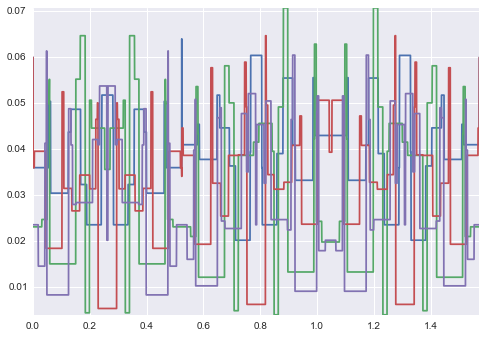

In [11]:
for i in range(9,13):
    x = linspace(0,pi/2,25*100)
    my_angles = array([angle_diff(xx,6,i) for xx in x])
    plot(x,my_angles)

axis('tight')

In [12]:
def best_angles(num_angles, amp):
    x = linspace(0,2*pi,100*amp)
    my_diffs = array([angle_diff(xx,3,12) for xx in x])
    best_offset = x[argmin(my_diffs)]
    return angles(best_offset, num_angles, amp)

In [13]:
%timeit best_angles(3,12)

10 loops, best of 3: 142 ms per loop


In [14]:
best_angles(3,12)

array([[  5.,  11.],
       [ -7.,  10.],
       [-12.,  -1.]])

In [15]:
def ideal_period(wavelength, NA = 0.85):
    '''
    All units are in mm
    '''
    pixel_size = 8.2/1000 #pixel size in mm for QXGA display (4DD)
    fl = 250 #focal length of lens in mm
    fl2 = 300 #focal length of the second lens
    ftube = 200 #focal length of the tube lens, for Nikon this is 200 mm
    wl = wavelength/10**6 #wavelength of light
    mag = 1/100
    sigma = sqrt(2) * 12/pixel_size/4 #std dev of gaussian beam in units of pixels at the SLM
    pupil_diameter = 2*NA*mag*fl2    #Size of pupil image at first fourier plane
    hole_radius = 2*wl*fl/(2* pi * sigma *sqrt(2) * pixel_size) #this is the limit of hole size
    hole_radius = 0.1/2# this is more reasonable (50 um)
    period = wl * fl * (1/(pupil_diameter/2 - hole_radius))/ pixel_size #in mm
    
    return period

In [16]:
#define model function and pass independant variables x and y as a list
def lor2D(xdata_tuple, amp, x0, y0, sigma_x, sigma_y, offset):
    (x, y) = xdata_tuple
    g = offset + amp/(1+((x-x0)/(sigma_x/2))**2)/(1+((y-y0)/(sigma_y/2))**2)
    return g

#create a wrapper function
def lor2D_fit(xdata_tuple, amp, x0, y0, sigma_x, sigma_y, offset):
    return lor2D(xdata_tuple, amp, x0, y0, sigma_x, sigma_y, offset).ravel()

In [54]:
%%timeit
'''
2D Lorentzian Fit
'''

angle = array([1,12])
n=1024
sizex = n
sizey = n

period = ideal_period(568,0.7)+0.01

test = patterntabArb(angle, period, 0.5, 0, 0., 5,n,n)

mindim = min(test.shape)

test_fft = abs(ifftshift(fftn(test[:mindim,:mindim])))

#I don't know why the first argument is negative?
my_angle = arctan2(-angle[0],angle[1])

peak = np.round(mindim/(period/array([sin(my_angle), cos(my_angle)])))

ex = 32/2

test_fft_sub = test_fft[n/2+peak[0]-ex:n/2+peak[0]+ex,n/2+peak[1]-ex:n/2+peak[1]+ex]

initial_guess = (test_fft_sub[ex,ex], ex, ex, 1/3, 1/3, 0)

x = arange(ex*2)
y = arange(ex*2)
xx, yy = np.meshgrid(x, y)

popt, pcov = curve_fit(lor2D_fit, (xx, yy), test_fft_sub.ravel(), p0=initial_guess)

precisepeak = peak-ex+popt[1:3]

preciseangle = arctan2(precisepeak[0],precisepeak[1])

precise_period = n/norm(precisepeak)
#precise_period = n/precisepeak[0]*sin(preciseangle)
print(n/precisepeak[0]*sin(preciseangle))

print('precisepeak = ',precisepeak)
print('precise_period = {:.8f}'.format(precise_period))

print('period = {:.8f}'.format(period))

8.43452429458
precisepeak =  [ -10.21954261  120.97489136]
precise_period = 8.43452429
period = 8.45735277
8.43452429458
precisepeak =  [ -10.21954261  120.97489136]
precise_period = 8.43452429
period = 8.45735277
8.43452429458
precisepeak =  [ -10.21954261  120.97489136]
precise_period = 8.43452429
period = 8.45735277
8.43452429458
precisepeak =  [ -10.21954261  120.97489136]
precise_period = 8.43452429
period = 8.45735277
1 loops, best of 3: 441 ms per loop


In [53]:
%%timeit
'''
2D parabola fit both x and y simultaneously
'''

angle = array([1,12])
n=1024
sizex = n
sizey = n

period = ideal_period(568,0.7)+0.01

test = patterntabArb(angle, period, 0.5, 0, 0., 5,n,n)

mindim = min(test.shape)

test_fft = abs(ifftshift(fftn(test[:mindim,:mindim])))

#I don't know why the first argument is negative?
my_angle = arctan2(-angle[0],angle[1])

peak = np.round(mindim/(period/array([sin(my_angle), cos(my_angle)])))

#pull the 3x3 region around the peak
region_size = 3
start = -(region_size-1)/2
end = region_size+start

test_fft_sub = test_fft[n/2+peak[0]+start:n/2+peak[0]+end,n/2+peak[1]+start:n/2+peak[1]+end]

x = arange(start,end)
xx, yy = np.meshgrid(x, x)

#We have to take our 2D data and transform it into a list of 2D coordinates
X = dstack((xx.ravel(),yy.ravel())).reshape((prod(test_fft_sub.shape),2))

#We have to ravel our data so that it is a list of points
vector = test_fft_sub.ravel()

#now we can continue as before
predict= X

#X_ = delete(X_,(3),axis=1)
#predict_ = delete(predict_,(3),axis=1)

poly = PolynomialFeatures(degree=2)
X_ = poly.fit_transform(X)
predict_ = poly.fit_transform(predict)
clf = linear_model.LinearRegression()
clf.fit(X_, vector)

#precisepeak = peak+poly2dmax(insert(clf.coef_,(3),0))
precisepeak = peak+poly2dmax(clf.coef_)

preciseangle = arctan2(precisepeak[0],precisepeak[1])

precise_period = n/norm(precisepeak)
#precise_period = n/precisepeak[0]*sin(preciseangle)
print(n/precisepeak[0]*sin(preciseangle))

print('precisepeak = ',precisepeak)
print('precise_period = {:.8f}'.format(precise_period))
print('period = {:.8f}'.format(period))

8.43355665622
precisepeak =  [ -10.10661771  120.998356  ]
precise_period = 8.43355666
period = 8.45735277
8.43355665622
precisepeak =  [ -10.10661771  120.998356  ]
precise_period = 8.43355666
period = 8.45735277
8.43355665622
precisepeak =  [ -10.10661771  120.998356  ]
precise_period = 8.43355666
period = 8.45735277
8.43355665622
precisepeak =  [ -10.10661771  120.998356  ]
precise_period = 8.43355666
period = 8.45735277
1 loops, best of 3: 424 ms per loop


In [52]:
%%timeit
'''
Parabola fit along x and y seperately
'''

angle = array([1,12])
n=1024
sizex = n
sizey = n

period = ideal_period(568,0.7)+0.01

test = patterntabArb(angle, period, 0.5, 0, 0., 5,n,n)

mindim = min(test.shape)

test_fft = abs(ifftshift(fftn(test[:mindim,:mindim])))

#I don't know why the first argument is negative?
my_angle = arctan2(-angle[0],angle[1])

peak = np.round(mindim/(period/array([sin(my_angle), cos(my_angle)])))

#pull the 3x3 region around the peak
region_size = 3
start = -(region_size-1)/2
end = region_size+start

x = arange(start,end)

test_fft_subx = test_fft[n/2+peak[0]+start:n/2+peak[0]+end,n/2+peak[1]]
test_fft_suby = test_fft[n/2+peak[0],n/2+peak[1]+start:n/2+peak[1]+end]

xfit = polyfit(x, test_fft_subx,2)
yfit = polyfit(x, test_fft_suby,2)

x0 = -xfit[1]/(2*xfit[0])
y0 = -yfit[1]/(2*yfit[0])

#precisepeak = peak+poly2dmax(insert(clf.coef_,(3),0))
precisepeak = peak+[x0,y0]

preciseangle = arctan2(precisepeak[0],precisepeak[1])

precise_period = n/norm(precisepeak)
#precise_period = n/precisepeak[0]*sin(preciseangle)
print(n/precisepeak[0]*sin(preciseangle))

print('precisepeak = ',precisepeak)
print('precise_period = {:.8f}'.format(precise_period))
print('period = {:.8f}'.format(period))

8.44143079403
precisepeak =  [ -10.00160521  120.89343502]
precise_period = 8.44143079
period = 8.45735277
8.44143079403
precisepeak =  [ -10.00160521  120.89343502]
precise_period = 8.44143079
period = 8.45735277
8.44143079403
precisepeak =  [ -10.00160521  120.89343502]
precise_period = 8.44143079
period = 8.45735277
8.44143079403
precisepeak =  [ -10.00160521  120.89343502]
precise_period = 8.44143079
period = 8.45735277
1 loops, best of 3: 432 ms per loop


In [65]:
#####
# THIS ONE WORKS
#####

def pattern_period(vecA, period, onfrac = 0.5, phaseInd = 0., phaseOffset = 0., nphases = 5, sizex =2048, sizey =1536):
    '''
    Find the precise pattern period
    
    Using 2nd order polynomial fit along either axis
    '''
    
    #this is a standin for nextpow2, I don't know if there's a more efficient one, but its not going to
    #be a bottle neck
    n = 1<<(min(sizex,sizey)-1).bit_length()
    
    my_pat = patterntabArb(vecA, period, onfrac, phaseInd, phaseOffset, nphases, n, n)
    
    my_pat_fft = abs(ifftshift(fftn(fftshift(my_pat))))

    #I don't know why the first argument is negative?
    my_angle = arctan2(-vecA[0],vecA[1])
    
    peak = np.round(n/(period/array([sin(my_angle), cos(my_angle)])))
    
    #pull the 3x3 region around the peak
    region_size = 3
    start = -(region_size-1)/2
    end = region_size+start

    my_pat_fft_subx = my_pat_fft[n/2+peak[0]+start:n/2+peak[0]+end,n/2+peak[1]]
    my_pat_fft_suby = my_pat_fft[n/2+peak[0],n/2+peak[1]+start:n/2+peak[1]+end]

    x = arange(start,end)
    
    xfit = polyfit(x, my_pat_fft_subx,2)
    yfit = polyfit(x, my_pat_fft_suby,2)

    x0 = -xfit[1]/(2*xfit[0])
    y0 = -yfit[1]/(2*yfit[0])

    #precisepeak = peak+poly2dmax(insert(clf.coef_,(3),0))
    precisepeak = peak+[x0,y0]
    #print(precisepeak)
    
    preciseangle = arctan2(precisepeak[0],precisepeak[1])
    
    #precise_period = n/norm(precisepeak)
    precise_period = n/precisepeak[0]*sin(preciseangle)
    
    #print('{:.20f}'.format(precise_period))
    
    return precise_period

In [16]:
pattern_period(angle, iperiod+0.01, phaseInd=1,sizex =1024)

8.4414097481379731

In [17]:
pattern_period(angle, iperiod+0.0, phaseInd=1,sizex =1024)

8.4358105910182868

In [62]:
def pattern_period(vecA, period, onfrac = 0.5, phaseInd = 0., phaseOffset = 0., nphases = 5, sizex =2048, sizey =1536):
    #this is a standin for nextpow2, I don't know if there's a more efficient one, but its not going to
    #be a bottle neck
    n = 1<<(min(sizex,sizey)-1).bit_length()
    
    my_pat = patterntabArb(vecA, period, onfrac, phaseInd, phaseOffset, nphases, n, n)
    
    my_pat_fft = abs(ifftshift(fftn(fftshift(my_pat))))

    #I don't know why the first argument is negative?
    my_angle = arctan2(-vecA[0],vecA[1])

    peak = np.round(n/(period/array([sin(my_angle), cos(my_angle)])));

    ex = 32/2

    my_pat_fft_sub = my_pat_fft[n/2+peak[0]-ex:n/2+peak[0]+ex,n/2+peak[1]-ex:n/2+peak[1]+ex]

    initial_guess = (my_pat_fft_sub[ex,ex], ex, ex, 1/3, 1/3, 0)

    x = arange(ex*2)
    y = arange(ex*2)
    xx, yy = np.meshgrid(x, y)
    
    popt, pcov = curve_fit(lor2D_fit, (xx, yy), my_pat_fft_sub.ravel(), p0=initial_guess)
    
    '''
    data_fitted = lor2D((x, y), *popt)
    fig, ax = plt.subplots(1, 1, figsize = (12,12))
    ax.hold(True)
    ax.matshow(test_fft_sub, origin='bottom', extent=(x.min(), x.max(), y.min(), y.max()))
    ax.contour(x, y, data_fitted, 8, colors='w')
    '''
    
    precisepeak = peak-ex+popt[1:3]
    
    preciseangle = arctan2(precisepeak[0],precisepeak[1])
    
    precise_period = n/precisepeak[0]*sin(preciseangle)
    
    
    return precise_period

In [58]:
def poly2dmax(coefs):
    '''
    Takes coefs from sklearn linear regression and returns max of 2D polynomial

    we assume the coefficients are returned as 1, x, y, x^2, xy, y^2

    '''

    A = coefs[3]
    B = coefs[5]
    C = coefs[1]
    D = coefs[2]
    E = coefs[4]
    F = coefs[0]

    x0 = -(2*B*C-D*E)/(4*A*B-E**2)
    y0 = -(2*A*D-C*E)/(4*A*B-E**2)

    return array([x0,y0])

def pattern_period(vecA, period, onfrac = 0.5, phaseInd = 0., phaseOffset = 0., nphases = 5, sizex =2048, sizey =1536):
    '''
    Find the precise pattern period
    
    We'll use a 2D polynomial fit to a 3 by 3 region around the peak to get a sub pixel estimate of the peak position
    '''
    
    #this is a standin for nextpow2, I don't know if there's a more efficient one, but its not going to be a
    #bottleneck
    n = 1<<(min(sizex,sizey)-1).bit_length()
    
    my_pat = patterntabArb(vecA, period, onfrac, phaseInd, phaseOffset, nphases, n, n)
    
    my_pat_fft = abs(ifftshift(fftn(fftshift(my_pat))))

    #I don't know why the first argument is negative?
    my_angle = arctan2(-vecA[0],vecA[1])
    
    peak = np.round(n/(period/array([sin(my_angle), cos(my_angle)])));
    
    #pull the 3x3 region around the peak
    region_size = 3
    start = -(region_size-1)/2
    end = region_size+start
    
    my_pat_fft_sub = my_pat_fft[n/2+peak[0]+start:n/2+peak[0]+end,n/2+peak[1]+start:n/2+peak[1]+end]

    x = arange(start,end)
    xx, yy = np.meshgrid(x, x)
    
    #We have to take our 2D data and transform it into a list of 2D coordinates
    X = dstack((xx.ravel(),yy.ravel())).reshape((prod(my_pat_fft_sub.shape),2))

    #We have to ravel our data so that it is a list of points
    vector = my_pat_fft_sub.ravel()

    poly = PolynomialFeatures(degree=2)
    X_ = poly.fit_transform(X)
    predict_ = poly.fit_transform(predict)
    
    #remove the cross term
    #X_ = delete(X_,(3),axis=1)
    #predict_ = delete(predict_,(3),axis=1)
    
    clf = linear_model.LinearRegression()
    clf.fit(X_, vector)

    #precisepeak = peak+poly2dmax(insert(clf.coef_,(3),0))
    precisepeak = peak+poly2dmax(clf.coef_)
    
    #print('{:.10f}, {:.10f}'.format(precisepeak[0],precisepeak[1]))
    
    preciseangle = arctan2(precisepeak[0],precisepeak[1])
    
    #precise_period = n/norm(precisepeak)
    precise_period = n/precisepeak[0]*sin(preciseangle)
    
    #print('{:.20f}'.format(precise_period))
    
    return precise_period

In [25]:
def objf(period):
    data = array([pattern_period(angle, period,phaseInd = n,sizex = 1024) for n in range(1)])
    return mean(abs(data-ideal_period(568))/ideal_period(568))

In [18]:
minimize(objf, ideal_period(568))

NameError: name 'minimize' is not defined

In [76]:
iperiod = ideal_period(568,0.7)
def objf(period,size):
    angle = array([1.,  12.])
    data = array([pattern_period(angle, period,0.8,phaseInd = n,sizex = size) for n in range(1)])
    return mean(abs(data-iperiod)/iperiod*100)

x = linspace(iperiod-0.2,iperiod+0.2,401)
y512 = array([objf(period,512) for period in x])
y1024 = array([objf(period,1024) for period in x])

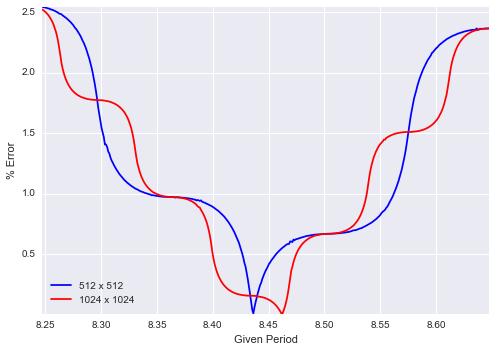

In [77]:
plot(x,y512,'b',label='512 x 512')
plot(x,y1024,'r',label='1024 x 1024')
axis('tight')
xlabel('Given Period')
ylabel('% Error')
legend(loc='best')
savefig("PeriodOpt_1_12_onfrac0.8.pdf")